In [105]:
#importovanje neophodnih biblioteka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#scikit learn preprocesiranje
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scikit learn selekcija feature-a
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import VarianceThreshold
#scikit learn izbor modela
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
#sklearn metrike 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, r2_score
#sklearn modeli
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
#sklearn model selection
from sklearn.model_selection import GridSearchCV
#sklearn za crossvalidation
from sklearn.model_selection import cross_val_score, cross_validate
#auto-sklearn
import autosklearn.classification
import autosklearn.regression
#scikit learn neuronske mreze
from sklearn.neural_network import MLPClassifier
#sklearn genetic-opt
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn_genetic import GAFeatureSelectionCV
#feature reduction sa PCA
from sklearn.decomposition import PCA

In [2]:
#ucitavanje podataka
file_name = "./datasets/addiction_nova.csv"
data = pd.read_csv(file_name, na_values = ' ')
data.head(10)

,ID,Pol,Godine,SkolaPoTipu,SkolaPoRegionu,Uspeh,EkonomskiPolozaj,ImaKomp,ZadovoljanPristupom,KolikoDugo,...,Internet16,Internet17,Internet18,NKP,PI,SPO,PUI,PUIcutoff,CutOff3940,CutOff4950
0,1,0.0,17.0,1,1,3.0,3.0,0.0,1.0,9.0,...,5.0,5.0,NaN,NaN,16.0,11.0,NaN,NaN,NaN,NaN
1,2,0.0,17.0,1,1,4.0,4.0,0.0,1.0,5.0,...,1.0,2.0,1.0,13.0,7.0,5.0,25.0,0.0,0.0,0.0
2,3,0.0,17.0,1,1,4.0,3.0,0.0,1.0,9.0,...,3.0,1.0,1.0,13.0,9.0,6.0,28.0,0.0,0.0,0.0
3,4,0.0,17.0,1,1,4.0,3.0,0.0,1.0,7.0,...,4.0,1.0,1.0,12.0,14.0,5.0,31.0,0.0,0.0,0.0
4,5,0.0,17.0,1,1,4.0,1.0,1.0,0.0,2.0,...,2.0,1.0,2.0,12.0,9.0,7.0,28.0,0.0,0.0,0.0
5,6,0.0,17.0,1,1,4.0,3.0,0.0,1.0,6.0,...,4.0,1.0,2.0,17.0,10.0,5.0,32.0,0.0,0.0,0.0
6,7,0.0,16.0,1,1,4.0,5.0,0.0,1.0,5.0,...,1.0,2.0,2.0,12.0,7.0,5.0,24.0,0.0,0.0,0.0
7,8,0.0,16.0,1,1,3.0,5.0,0.0,1.0,8.0,...,2.0,1.0,1.0,13.0,12.0,6.0,31.0,0.0,0.0,0.0
8,9,1.0,17.0,1,1,5.0,2.0,0.0,1.0,5.0,...,5.0,2.0,4.0,32.0,20.0,9.0,61.0,1.0,1.0,1.0
9,10,0.0,16.0,1,1,4.0,1.0,0.0,0.0,6.0,...,4.0,1.0,1.0,9.0,10.0,4.0,23.0,0.0,0.0,0.0


In [3]:
#provera da li ima duplikata
print('Broj pronadjenih duplikata: ' + str(data.duplicated().sum()))

Broj pronadjenih duplikata: 0


In [4]:
#sredjivanje kolona
#kolone ID, TEMPS1 do TEMPS36, NKP, PI, SPO, CutOff4950, EnergetskoP2 ne ulaze u analizu
temp_cols=[]
for col in data.columns:
    if col.startswith('TEMPS'):
        temp_cols.append(col)
out_cols = ['ID','NKP','PI','SPO', 'CutOff4950', 'EnergetskoP2']
for col in out_cols:
    temp_cols.append(col)
new_data = data.drop(temp_cols, axis=1)
#preimenovanje kolone
new_data.rename(columns = {'CutOff3940':'Cutoff_Class'}, inplace=True)

In [5]:
#eliminacija Internet kolona (Internet1 -> Internet18)
internet_cols=[]
for col in new_data.columns:
    if col.startswith('Internet'):
        internet_cols.append(col)
new_data = new_data.drop(internet_cols, axis=1)
print('Novi broj kolona nakon eliminacije: {}'.format(len(new_data.columns)))

Novi broj kolona nakon eliminacije: 76


In [6]:
#provera koliko ima NaN vrednosti
print(new_data.isna().sum().sort_values(ascending=False))
#za Cutoff_Class kolonu postoji 104 NaN vrednosti, to je otprilike 5% celokupnog dataset-a
#brisemo redove koji imaju NaN vrednost u Cutoff_Class koloni
new_data = new_data.dropna(subset=['Cutoff_Class', 'PUI'])

PusacKolikoGodina      208
PusacKolikoCigareta    196
Komunikacija4          145
Komunikacija2          130
Cutoff_Class           104
                      ... 
Anksiozni                0
Temper_bin               0
SkolaPoRegionu           0
SkolaPoTipu              0
FBgrupe                  0
Length: 76, dtype: int64


In [7]:
#kolone sa samo binarnim vrednostima
zero_one = ['Pol','ImaKomp','ZadovoljanPristupom','KolikoNedeljno',
                 'DaMozeDaLiBi','BrojaMailovaPosl','DaLiSvakodnevnoFb',
                 'ImaNemaFB','FBcitaPostove','FBpiseStatuse','FBdeliMuzikuFotografijeIsl', 
                 'FBigraIgrice','FBcetuje','FBgrupe','EnergetskoP1','Grickalice','Pusac',
                 'Kafa_bin','Alkohol_bin','DaLiSeDrogira','Temper_bin','PUI']

zero_one_with_NaN = list()
for col in new_data[zero_one]:
    if(new_data[col].isna().sum()>0):
        zero_one_with_NaN.append(col)
#provera koje od ovih kolona imaju NaN vrednosti
print(new_data[zero_one].isna().sum().sort_values(ascending=False))

BrojaMailovaPosl              57
Grickalice                    39
EnergetskoP1                  33
ImaKomp                       31
KolikoNedeljno                30
DaMozeDaLiBi                  24
DaLiSvakodnevnoFb             24
Kafa_bin                      24
Alkohol_bin                   16
Pusac                         16
DaLiSeDrogira                 14
ZadovoljanPristupom           10
Pol                            1
Temper_bin                     0
FBigraIgrice                   0
FBgrupe                        0
FBcetuje                       0
FBdeliMuzikuFotografijeIsl     0
FBpiseStatuse                  0
FBcitaPostove                  0
ImaNemaFB                      0
PUI                            0
dtype: int64


In [8]:
#zamena vrednosti za kolone sa binarnim vrednostima koje imaju NaN vrednosti
for col in new_data[zero_one_with_NaN].columns:
    zero_row_num = new_data[col].value_counts()[0.0]
    one_row_num = new_data[col].value_counts()[1.0]
    if (zero_row_num > one_row_num):
        swap_value = 0
    else:
        swap_value = 1
    new_data[col] = new_data[col].fillna(swap_value)
print(new_data[zero_one_with_NaN].isna().sum().sort_values(ascending=False))

Pol                    0
ImaKomp                0
ZadovoljanPristupom    0
KolikoNedeljno         0
DaMozeDaLiBi           0
BrojaMailovaPosl       0
DaLiSvakodnevnoFb      0
EnergetskoP1           0
Grickalice             0
Pusac                  0
Kafa_bin               0
Alkohol_bin            0
DaLiSeDrogira          0
dtype: int64


In [9]:
#kolone gde se iste vrednosti pojavljuju cesto
repeat_value_cols = ['Godine', 'SkolaPoTipu', 'SkolaPoRegionu','Uspeh','EkonomskiPolozaj','KolikNajduze',
                     'Predhodnih6meseci','ZaStaMail','FizAkt1','FizAkt2','PusacKolikoGodina','PusacKolikoCigareta']

for col in new_data.columns:
    if (col.startswith('Sadrzaj') or col.startswith('Aktivnost') or col.startswith('Internet')):
        repeat_value_cols.append(col)
print(repeat_value_cols)

['Godine', 'SkolaPoTipu', 'SkolaPoRegionu', 'Uspeh', 'EkonomskiPolozaj', 'KolikNajduze', 'Predhodnih6meseci', 'ZaStaMail', 'FizAkt1', 'FizAkt2', 'PusacKolikoGodina', 'PusacKolikoCigareta', 'Sadrzaj1', 'Sadrzaj2', 'Sadrzaj3', 'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj6', 'Sadrzaj7', 'Sadrzaj8', 'Sadrzaj9', 'Sadrzaj10', 'Sadrzaj11', 'Sadrzaj12', 'Sadrzaj13', 'Aktivnost1', 'Aktivnost2', 'Aktivnost3', 'Aktivnost4', 'Aktivnost5', 'Aktivnost6', 'Aktivnost7', 'Aktivnost8', 'Aktivnost9', 'Aktivnost10', 'Aktivnost11', 'Aktivnost12', 'Aktivnost13', 'Aktivnost14']


In [10]:
#zamena nedostajucih vrednosti kod kolona gde se iste vrednosti pojavljuju cesto
repeat_cols_with_NaN = list()
for col in new_data[repeat_value_cols]:
    if(new_data[col].isna().sum()>0):
        repeat_cols_with_NaN.append(col)
        
for col in new_data[repeat_cols_with_NaN]:
    mode = new_data[col].mode()[0]
    new_data[col] = new_data[col].fillna(mode)
print(new_data[repeat_cols_with_NaN].isna().sum().sort_values(ascending=False))

Godine                 0
Sadrzaj10              0
Sadrzaj12              0
Sadrzaj13              0
Aktivnost1             0
Aktivnost2             0
Aktivnost3             0
Aktivnost4             0
Aktivnost5             0
Aktivnost6             0
Aktivnost7             0
Aktivnost8             0
Aktivnost9             0
Aktivnost10            0
Aktivnost11            0
Aktivnost12            0
Aktivnost13            0
Sadrzaj11              0
Sadrzaj9               0
Uspeh                  0
Sadrzaj8               0
EkonomskiPolozaj       0
KolikNajduze           0
Predhodnih6meseci      0
ZaStaMail              0
FizAkt1                0
FizAkt2                0
PusacKolikoGodina      0
PusacKolikoCigareta    0
Sadrzaj1               0
Sadrzaj2               0
Sadrzaj3               0
Sadrzaj4               0
Sadrzaj5               0
Sadrzaj6               0
Sadrzaj7               0
Aktivnost14            0
dtype: int64


In [11]:
#zamena nedostajucih vrednosti kod kolona sa nebinarnim vrednostima sa srednjom vrednoscu
filter_cols = zero_one + repeat_value_cols
non_binary_cols = new_data.columns.difference(filter_cols).values
non_binary_cols_with_NaN = list()
for col in new_data[non_binary_cols]:
    if(new_data[col].isna().sum()>0):
        non_binary_cols_with_NaN.append(col)
for col in new_data[non_binary_cols_with_NaN]:
    mean = new_data[col].mean()
    new_data[col] = new_data[col].fillna(mean)

In [12]:
#provera da li nakon preprocesiranja ima NaN vrednosti
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ): print(new_data.isna().sum().sort_values(ascending=False))

Pol                           0
FBdeliMuzikuFotografijeIsl    0
Komunikacija4                 0
Komunikacija3                 0
Komunikacija2                 0
Komunikacija1                 0
FBgrupe                       0
FBcetuje                      0
FBigraIgrice                  0
FBpiseStatuse                 0
Godine                        0
FBcitaPostove                 0
BrojaSatiFB                   0
ImaNemaFB                     0
DaLiSvakodnevnoFb             0
ZaStaMail                     0
BrojaMailovaPosl              0
BrojaMailovaPrim              0
FizAkt1                       0
FizAkt2                       0
FizAkt3                       0
EnergetskoP1                  0
PUIcutoff                     0
PUI                           0
Temper_bin                    0
Anksiozni                     0
Iritabilni                    0
Hipertimicni                  0
Ciklotimicni                  0
Depresivan                    0
DaLiSeDrogira                 0
Alkohol_

In [13]:
#provera tipova podataka
pd.set_option('display.max_rows', len(data.axes[1]))
#kolone sa float vrednostima su Depresivan, Ciklotimicni, Hipertimicni, Iritabilni, Anksiozni
int_columns = new_data.columns.difference(['Depresivan', 'Ciklotimicni', 'Hipertimicni','Iritabilni','Anksiozni', 'BrojaSatiFB']).values

In [53]:
#podesavanje input i output kolone
input_cols = new_data[new_data.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
output_col = new_data['Cutoff_Class']

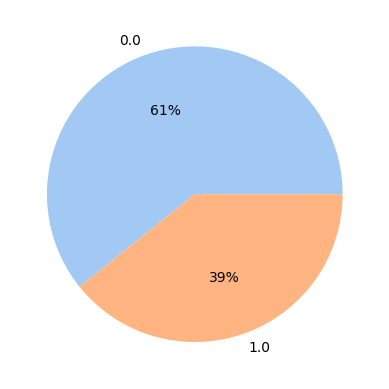

In [15]:
#pie chart za prikaz raspodele po klasama
labels = pd.unique(new_data['Cutoff_Class'])
countByClass = new_data.groupby('Cutoff_Class').size()
colors = sns.color_palette('pastel')[0:2]
plt.pie(countByClass, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [16]:
#pregled outlier vrednosti po kolonama
#detekcija outliera pomocu iqr
def find_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3=  df[col_name].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = df[((df[col_name]<(q1-1.5*iqr)) | (df[col_name]>(q3+1.5*iqr)))]
    return outliers
cols_to_use = new_data[new_data.columns.difference(zero_one)]
total_outlier_num=0
cols = cols_to_use.columns.values
num_cols=[]
for col in cols:
    num = find_outliers(cols_to_use, col)
    num_cols.append(len(num))
new_data_frame = pd.DataFrame()
new_data_frame['Feature']= cols
new_data_frame['Outliers']= num_cols
#print(new_data_frame.sort_values('Outliers', ascending=False))

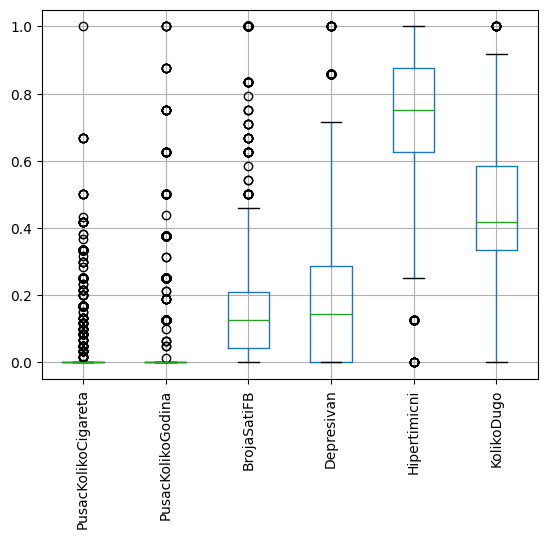

In [17]:
#ima smisla prikazivati outliere kod onih kolona gde se ne ponavljaju vrednosti iz predefinisanog skupa
outlier_cols = ['PusacKolikoCigareta','PusacKolikoGodina','BrojaSatiFB','Depresivan','Hipertimicni','KolikoDugo'] 
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
#pravimo kopiju da originalni set ne bi bio promenjen
outlier_data_norm = new_data.copy()
outlier_data_robust = new_data.copy()
outlier_data_norm[outlier_cols]= minmax_scaler.fit_transform(new_data[outlier_cols])
outlier_data_robust[outlier_cols]= robust_scaler.fit_transform(new_data[outlier_cols])
#prikaz outliera na boxplot-u
outlier_data_norm[outlier_cols].boxplot(rot=90)
#new_data[outlier_cols].boxplot(rot=90)
plt.show()
#outlier_data_robust[outlier_cols].boxplot(rot=90)

In [18]:
#normalizacija podataka -> normalizujemo sve kolone osim onih koje imaju samo binarne vrednosti 
cols_to_normalize = input_cols.columns.difference(zero_one)
min_max = MinMaxScaler()
new_data_norm = new_data.copy()
new_data_norm[cols_to_normalize] = min_max.fit_transform(new_data_norm[cols_to_normalize])

In [19]:
#standardizacija podataka
cols_to_standardize = input_cols.columns.difference(zero_one)
standard_scaler = StandardScaler()
new_data_standard = new_data.copy()
new_data_standard[cols_to_standardize] = standard_scaler.fit_transform(new_data_standard[cols_to_standardize])

In [20]:
#feture selection sa low variance metodom
variance = VarianceThreshold(threshold=0.3)
variance = variance.fit(input_cols,output_col)
good_features = variance.get_support()
print(input_cols.columns[good_features])

Index(['Aktivnost1', 'Aktivnost10', 'Aktivnost11', 'Aktivnost12',
       'Aktivnost13', 'Aktivnost14', 'Aktivnost2', 'Aktivnost3', 'Aktivnost4',
       'Aktivnost5', 'Aktivnost6', 'Aktivnost7', 'Aktivnost8', 'Aktivnost9',
       'BrojaSatiFB', 'EkonomskiPolozaj', 'FizAkt1', 'FizAkt2', 'FizAkt3',
       'KolikNajduze', 'KolikoDugo', 'Komunikacija1', 'Komunikacija2',
       'Komunikacija3', 'Komunikacija4', 'Predhodnih6meseci',
       'PusacKolikoCigareta', 'PusacKolikoGodina', 'Sadrzaj1', 'Sadrzaj10',
       'Sadrzaj11', 'Sadrzaj12', 'Sadrzaj13', 'Sadrzaj2', 'Sadrzaj3',
       'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj6', 'Sadrzaj7', 'Sadrzaj8', 'Sadrzaj9',
       'SkolaPoRegionu', 'SkolaPoTipu', 'Uspeh'],
      dtype='object')


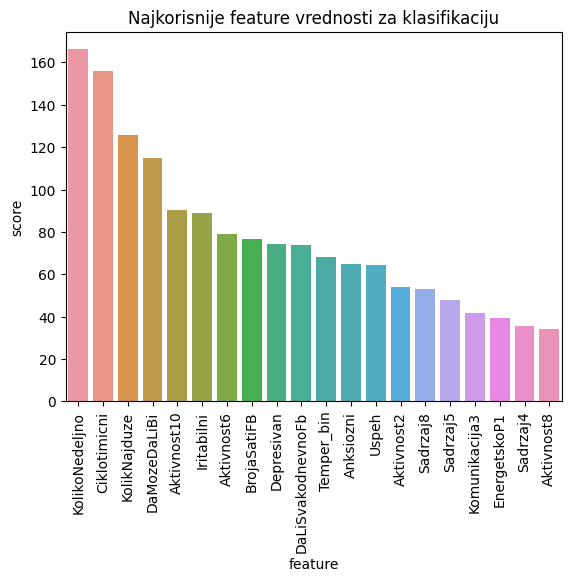

In [21]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za klasifikaciju
best_features = SelectKBest(score_func = f_regression, k=20)
calc_features = best_features.fit(input_cols,output_col)
#odabir 30 najboljih feature-a
usefull_features = pd.DataFrame({'feature' : input_cols.columns.values, 'score' : calc_features.scores_})
most_usefull_features = usefull_features.sort_values(by=['score'],ascending=False).head(20)
#vizuelizacija dobijenih rezultata
plt.title('Najkorisnije feature vrednosti za klasifikaciju')
plt.xlabel('Feature score')
plt.xticks(rotation=90)
plt.ylabel('Naziv kolone')

sns.barplot(x=most_usefull_features['feature'], y=most_usefull_features['score'])
#plt.barh(most_usefull_features['feature'], most_usefull_features['score'])
plt.show()

Index(['KolikoNedeljno', 'KolikNajduze', 'DaMozeDaLiBi', 'Aktivnost10',
       'Ciklotimicni', 'Iritabilni', 'PUI', 'PUIcutoff', 'Cutoff_Class'],
      dtype='object')


<AxesSubplot: >

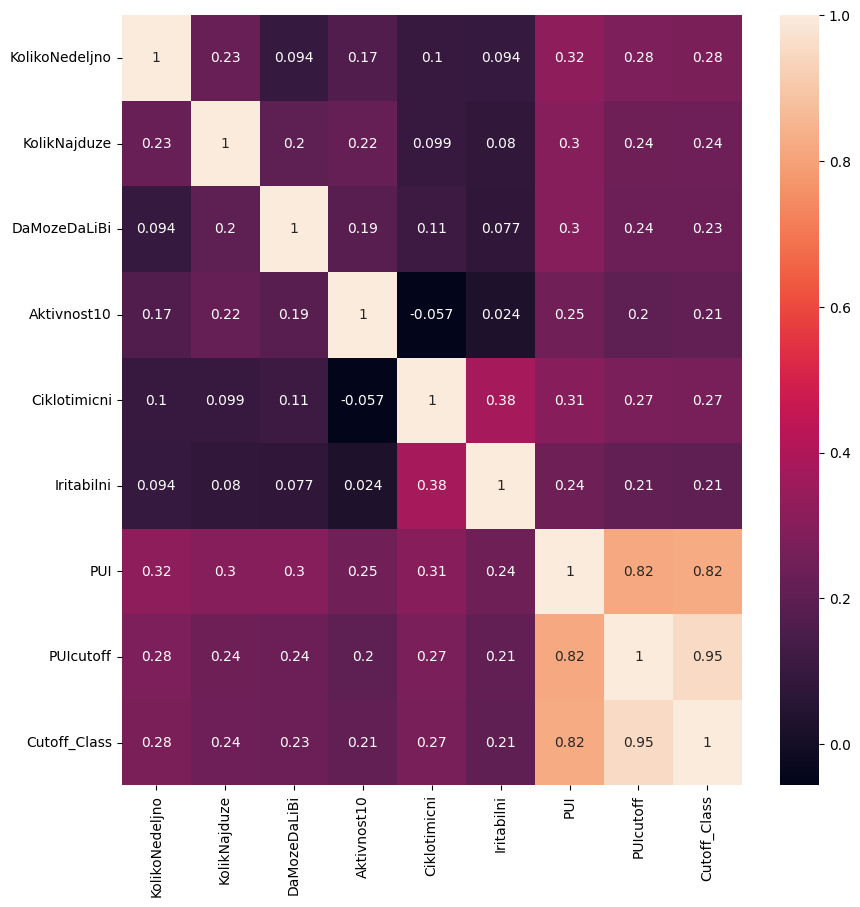

In [22]:
#prikaz heat mape gde se vide koeficijenti korelacije
plt.figure(figsize=(10,10))
correlation = new_data.corr()
correlation_treshold = correlation['Cutoff_Class']
good_features = correlation_treshold[abs(correlation_treshold>0.2)]
print(str(good_features.keys()))
#print(good_features.sort_values(ascending=False))
sns.heatmap(new_data[good_features.keys()].corr(), annot=True)

In [23]:
#podela na train i test set
X_cols = new_data[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col = new_data['Cutoff_Class']
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)

In [24]:
#DEO SA KLASIFIKACIJOM
decision_tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
knn = KNeighborsClassifier()
random_forest = RandomForestClassifier()
grad_boost_class = GradientBoostingClassifier()

In [25]:
#neuronske mreze za klasifikaciju
X_cols = new_data_standard[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col = new_data_standard['Cutoff_Class']
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)
mlp = MLPClassifier(
    hidden_layer_sizes=(40,),
    max_iter= 90,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
)
trained_model = mlp.fit(X_train, y_train)
y_preds = trained_model.predict(X_test)
plt.show()
print('Accuracy za dataset sa MLP-om: {:.2f}'.format(trained_model.score(X_test, y_test)))
print('Classification report za model sa MLP-om: ')
print(classification_report(y_test, y_preds))

Iteration 1, loss = 0.64665841
Iteration 2, loss = 0.55983106
Iteration 3, loss = 0.53500378
Iteration 4, loss = 0.51686357
Iteration 5, loss = 0.52848684
Iteration 6, loss = 0.46243473
Iteration 7, loss = 0.44924811
Iteration 8, loss = 0.44342783
Iteration 9, loss = 0.42919534
Iteration 10, loss = 0.38697314
Iteration 11, loss = 0.35501871
Iteration 12, loss = 0.37324797
Iteration 13, loss = 0.32328984
Iteration 14, loss = 0.30373676
Iteration 15, loss = 0.29348775
Iteration 16, loss = 0.46228219
Iteration 17, loss = 0.37051377
Iteration 18, loss = 0.30456571
Iteration 19, loss = 0.29877915
Iteration 20, loss = 0.23078419
Iteration 21, loss = 0.19337492
Iteration 22, loss = 0.16369677
Iteration 23, loss = 0.29144139
Iteration 24, loss = 0.22541695
Iteration 25, loss = 0.17365399
Iteration 26, loss = 0.16829562
Iteration 27, loss = 0.18200383
Iteration 28, loss = 0.14196663
Iteration 29, loss = 0.09316790
Iteration 30, loss = 0.07678355
Iteration 31, loss = 0.05867711
Iteration 32, los

In [36]:
#genetski algoritmi
parameters = {'n_estimators':[10,50,100], 
              'criterion': ['gini', 'entropy'],
              'max_features': list(range(3,8)),
              'max_depth': [2,4,9]
               }
param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 11),
              'max_leaf_nodes': Integer(2, 15),
              'n_estimators': Integer(100,300)}

clf = RandomForestClassifier()

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                              cv=cv,
                              scoring='accuracy',
                              n_jobs=-1,
                              param_grid = param_grid,
                              verbose=True)

evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.674052	0.0450218  	0.728677   	0.604854   
1  	100   	0.709793	0.0255086  	0.731794   	0.615433   
2  	100   	0.722252	0.00622666 	0.734917   	0.710019   
3  	100   	0.725813	0.00404461 	0.734917   	0.712516   
4  	100   	0.72697 	0.00418411 	0.734917   	0.711264   
5  	100   	0.727591	0.00339745 	0.734917   	0.718735   
6  	100   	0.727903	0.00402021 	0.733672   	0.714376   
7  	100   	0.728922	0.0037066  	0.733672   	0.719358   
8  	100   	0.729694	0.00308837 	0.734289   	0.723702   
9  	100   	0.729571	0.00347877 	0.738011   	0.723081   
10 	100   	0.730902	0.00344206 	0.738011   	0.720599   
11 	100   	0.730178	0.00382303 	0.734915   	0.719347   
12 	100   	0.730491	0.00341952 	0.734906   	0.719984   
13 	100   	0.730852	0.00282256 	0.734919   	0.724335   
14 	100   	0.731126	0.00319205 	0.734919   	0.723719   
15 	100   	0.730355	0.00370469 	0.734906   	0.722451   
16 	100   	0.730281	0.0042765  	0.734906   	0.71

GASearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
           estimator=RandomForestClassifier(bootstrap=False, max_depth=6,
                                            max_leaf_nodes=15,
                                            min_weight_fraction_leaf=0.018485202503559072,
                                            n_estimators=288),
           n_jobs=-1,
           param_grid={'bootstrap': <sklearn_genetic.space.space.Categorical object at 0x7fcf605ac0a0>,
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x7fcf605ade10>,
                       'max_leaf_nodes': <sklearn_genetic.space.space.Integer object at 0x7fcf605ae170>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x7fcf605ac700>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x7fcf605afb50>},
           return_train_score=True, scoring='accuracy')

In [37]:
#rezultati koriscenjem genetskih algoritama
y_predict_ga = evolved_estimator.predict(X_test)
print(accuracy_score(y_test, y_predict_ga))

0.7238805970149254


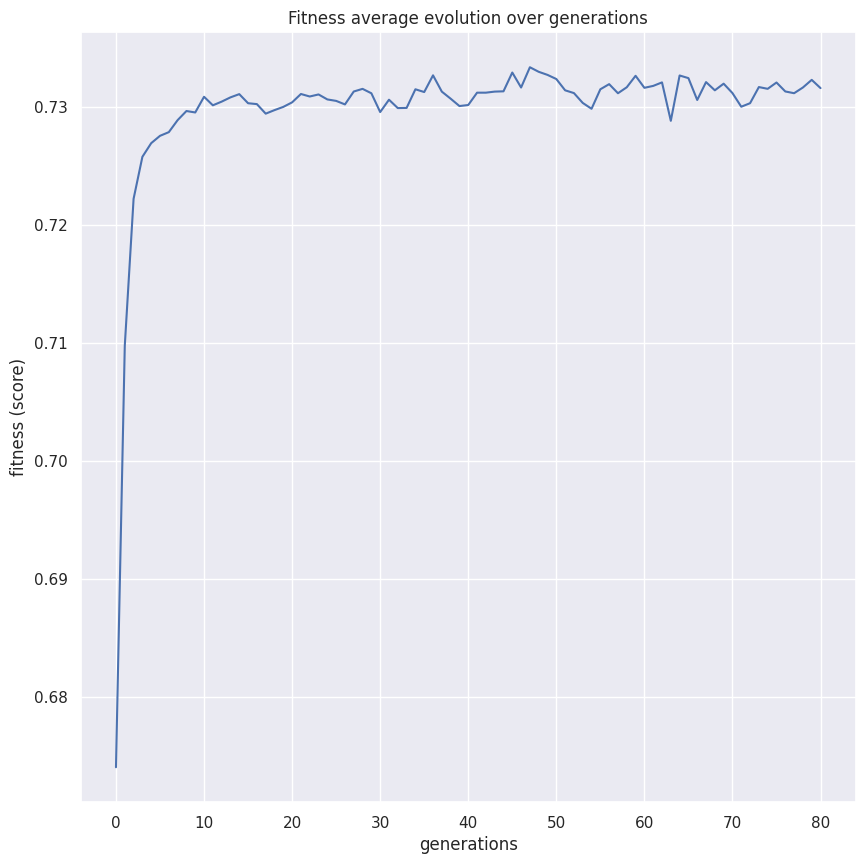

In [43]:
#prikaz evolucije fitnes funkcije kroz generacije
plot_fitness_evolution(evolved_estimator)
plt.show()

In [44]:
#feature selection koriscenjem genetskih algoritama
clf = RandomForestClassifier()
evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=3,
    scoring="accuracy",
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    keep_top_k=2,
    elitism=True,
)
evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.694072	0.0206974  	0.71812    	0.62165    
1  	60    	0.707639	0.0103571  	0.723725   	0.67704    
2  	60    	0.715066	0.00512703 	0.723101   	0.701935   
3  	60    	0.718239	0.00548208 	0.734917   	0.706909   
4  	60    	0.720936	0.00553438 	0.733676   	0.706909   
5  	60    	0.723635	0.00546419 	0.733676   	0.70816    
6  	60    	0.725896	0.00418881 	0.734924   	0.71749    
7  	60    	0.725834	0.00442292 	0.734924   	0.717495   
8  	60    	0.729174	0.00611668 	0.738033   	0.714378   
9  	60    	0.732474	0.00447587 	0.738033   	0.724339   
10 	60    	0.7349  	0.00336457 	0.741772   	0.727459   
11 	60    	0.73382 	0.00412748 	0.739278   	0.722474   
12 	60    	0.733654	0.00400645 	0.739278   	0.722469   
13 	60    	0.732867	0.00489383 	0.739888   	0.719367   
14 	60    	0.735044	0.00297105 	0.739888   	0.7287     
15 	60    	0.734215	0.00405174 	0.739888   	0.72434    
16 	60    	0.734381	0.00331091 	0.739888   	0.72

GAFeatureSelectionCV(estimator=RandomForestClassifier(), generations=20,
                     keep_top_k=2, n_jobs=-1, population_size=30,
                     return_train_score=True, scoring='accuracy')

In [101]:
#feature selection koriscenjem genetskih alogiritama 
gen_opt_features = evolved_estimator.best_features_
gen_df = pd.DataFrame({'feature': X_train.columns, 'is_used':gen_opt_features})

def highlight_cells(val):
    color = 'yellow' if val == True else ''
    return 'background-color: {}'.format(color)

selected_features = gen_df[gen_df['is_used'] == True]['feature']
gen_df.style.applymap(highlight_cells)

,feature,is_used
0,Aktivnost1,True
1,Aktivnost10,True
2,Aktivnost11,True
3,Aktivnost12,True
4,Aktivnost13,True
5,Aktivnost14,False
6,Aktivnost2,True
7,Aktivnost3,False
8,Aktivnost4,True
9,Aktivnost5,False


In [104]:
#predikcija koriscenjem feature-a odabranih genetskim algoritmom
y_predict_ga = evolved_estimator.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_predict_ga)
print(accuracy)

0.7711442786069652


In [ ]:
#radimo sa standardizovanim datasetom
X_cols_norm = new_data_norm[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col_norm = new_data_norm['Cutoff_Class']
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)

In [331]:
#principal component analysis za feature reduction

pca = PCA(n_components = 10)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
print(pca.explained_variance_ratio_)

clr = RandomForestClassifier()
clr.fit(X_train, y_train)

y_pred_pca = clr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_pca)
print(accuracy)

[0.2037068  0.16195784 0.14761088 0.08831019 0.07949808 0.07507513
 0.07165907 0.06428111 0.05611512 0.05178578]
0.7039800995024875


In [340]:
# k-fold cross-validation za razne modele ML-a
models = [
            ('Decision Tree', decision_tree), 
            ('Gaussian Naive Bayes', naive_bayes), 
            ('K-Nearest Neighbors', knn), 
            ('Random Forest', random_forest),
            ('Gradient Boosting Classifier', grad_boost_class)]
results = []
results_accuracy = []
results_recall = []
results_f1 = []
names = []
k_fold = StratifiedKFold(n_splits=10)
for name, model in models:
    cv_res = cross_validate(model, X_train, y_train, cv=k_fold, scoring=['accuracy', 'recall','f1'])
    results.append(cv_res)
    results_accuracy.append(cv_res['test_accuracy'].mean())
    results_recall.append(cv_res['test_recall'].mean())
    results_f1.append(cv_res['test_f1'].mean())
    names.append(name)

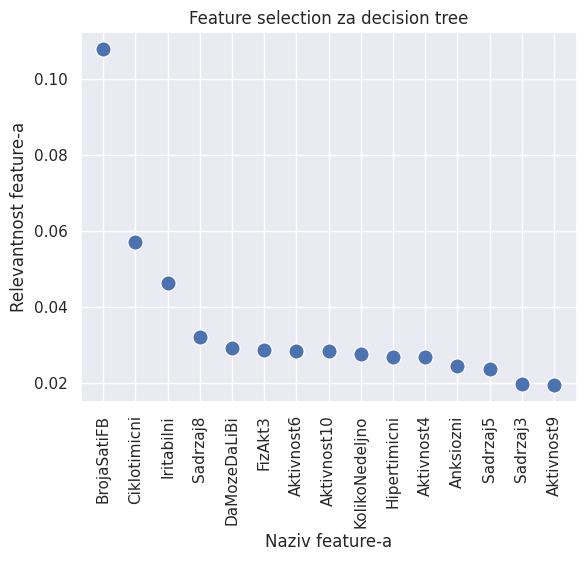

In [27]:
#feature selection za decision tree
sns.set()
decision_tree.fit(X_cols, y_col)
values = decision_tree.feature_importances_
attr_names = X_cols.columns.values
tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
tree_features = tree_features.sort_values(by='values', ascending=False).head(15)
sns.scatterplot(x = tree_features['attr_names'], y=tree_features['values'], s=120)
title = 'Feature selection za decision tree'
plt.title(title)
plt.xlabel('Naziv feature-a')
plt.xticks(rotation=90)
plt.ylabel('Relevantnost feature-a')
plt.show()
#cuvanje najkorisnijih feature-a
best_decision_tree_features = tree_features['attr_names']

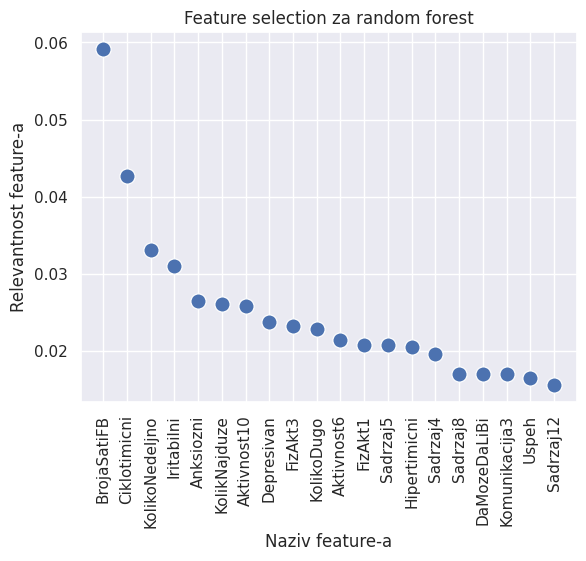

In [28]:
#feature selection za random forest
random_forest.fit(X_cols, y_col)
values = random_forest.feature_importances_
attr_names = X_cols.columns.values
tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
tree_features = tree_features.sort_values(by='values', ascending=False).head(20)
sns.scatterplot(x = tree_features['attr_names'], y=tree_features['values'], s=120)
title = 'Feature selection za random forest'
plt.title(title)
plt.xlabel('Naziv feature-a')
plt.xticks(rotation=90)
plt.ylabel('Relevantnost feature-a')
plt.show()
#cuvanje najkorisnijih feature-a
best_random_forest_features = tree_features['attr_names']

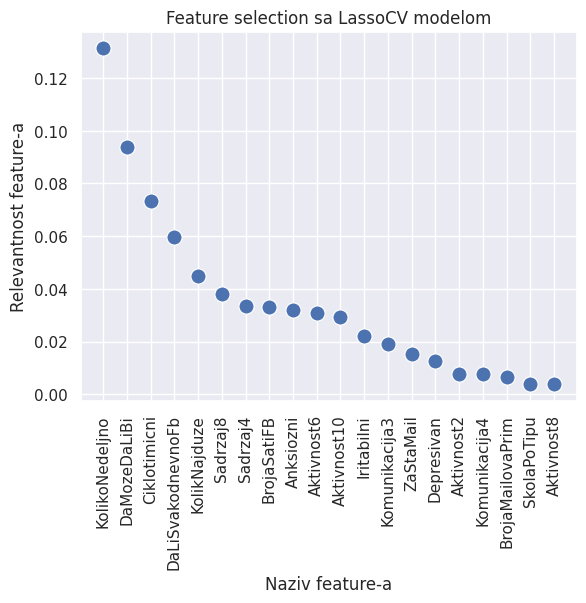

In [29]:
#feature selection sa LassoCV modelom 
lasso = LassoCV(cv=3)                                                   
lasso.fit(X_cols, y_col)      
lasso_values = lasso.coef_
attr_names = X_cols.columns.values
lasso_features = pd.DataFrame({'attr_names':attr_names, 'values':lasso_values})
lasso_features = lasso_features.sort_values(by='values', ascending=False).head(20)       
sns.scatterplot(x = lasso_features['attr_names'], y=lasso_features['values'], s=120)
title = 'Feature selection sa LassoCV modelom'
plt.title(title)
plt.xlabel('Naziv feature-a')
plt.xticks(rotation=90)
plt.ylabel('Relevantnost feature-a')
plt.show()
#cuvanje najkorisnijih feature-a
best_lasso_features = lasso_features['attr_names']

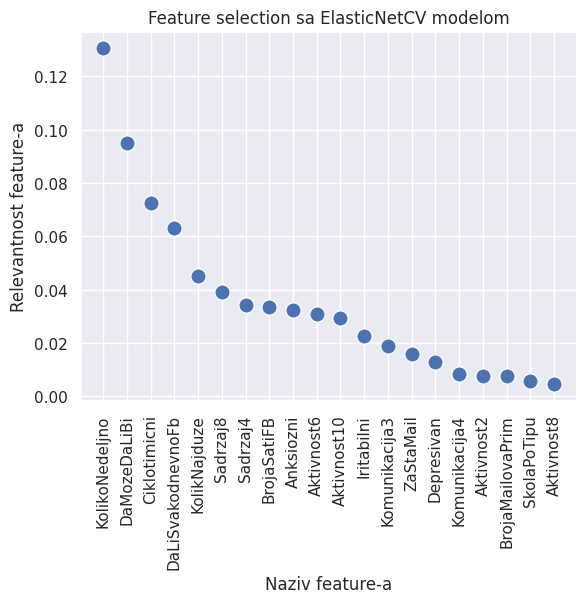

In [30]:
#feature selection koriscenjem ElasticNetCV modela
el_net = ElasticNetCV(cv=3)
el_net.fit(X_cols, y_col)
el_net_values = el_net.coef_
attr_names = X_cols.columns.values
el_net_features = pd.DataFrame({'attr_names':attr_names, 'values':el_net_values})
el_net_features = el_net_features.sort_values(by='values', ascending=False).head(20)       
sns.scatterplot(x = el_net_features['attr_names'], y=el_net_features['values'], s=120)
title = 'Feature selection sa ElasticNetCV modelom'
plt.title(title)
plt.xlabel('Naziv feature-a')
plt.xticks(rotation=90)
plt.ylabel('Relevantnost feature-a')
plt.show()
#cuvanje najkorisnijih feature-a
best_el_net_features = el_net_features['attr_names']

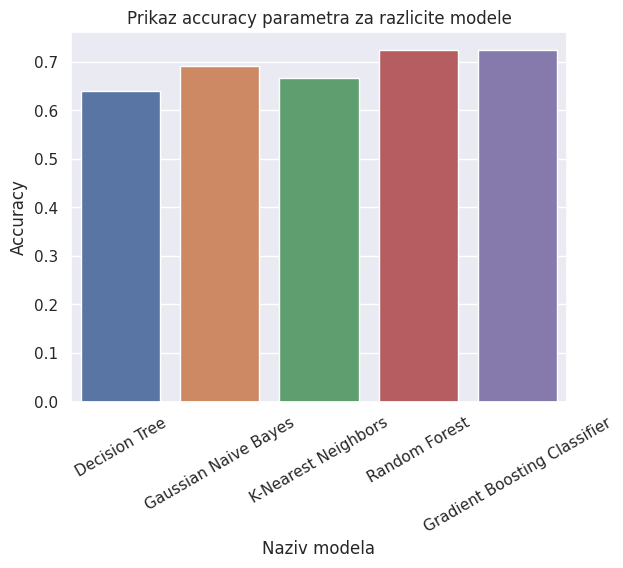

In [31]:
#vizuelizacija dobijenih rezultata za accuracy
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'accuracy':results_accuracy})
sns.barplot(x = frame['model_name'], y=frame['accuracy'])
title = 'Prikaz accuracy parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Accuracy')
plt.show()

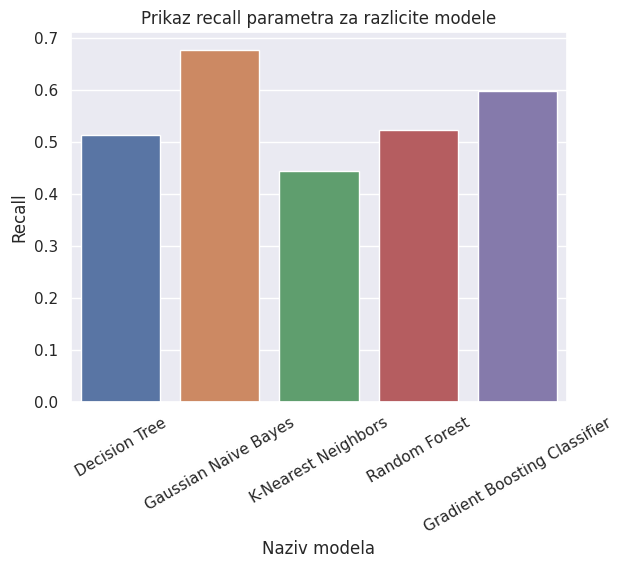

In [32]:
#vizuelizacija dobijenih rezultata za recall
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'recall':results_recall})
sns.barplot(x = frame['model_name'], y=frame['recall'])
title = 'Prikaz recall parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Recall')
plt.show()

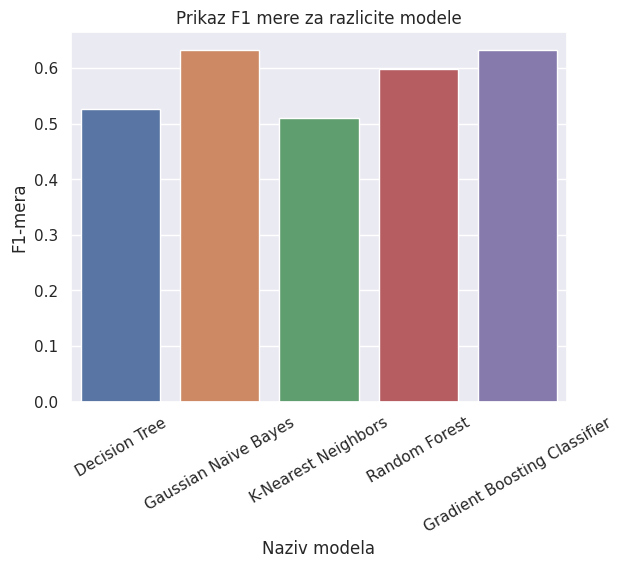

In [33]:
#vizuelizacija dobijenih rezultata za f1
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'f1':results_f1})
sns.barplot(x = frame['model_name'], y=frame['f1'])
title = 'Prikaz F1 mere za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('F1-mera')
plt.show()

In [34]:
#dataset sa najboljim feature-ima za decision tree model
X_decision_tree = new_data[best_decision_tree_features]
y_decision_tree = new_data['Cutoff_Class']
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(X_decision_tree, y_decision_tree, test_size=0.2)

#dataset sa 20 najboljih feature-a za random forest model
X_random_forest = new_data[best_random_forest_features]
y_random_forest = new_data['Cutoff_Class']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_random_forest, y_random_forest, test_size=0.2)

#dataset sa najboljim feature-ima za elastic-net model
X_elastic_net = new_data[best_el_net_features]
y_elastic_net = new_data['Cutoff_Class']
X_train_el_net, X_test_el_net, y_train_el_net, y_test_el_net = train_test_split(X_elastic_net, y_elastic_net, test_size=0.2)

#normalizovan dataset
X_norm = new_data_norm[new_data_norm.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
#X_norm = new_data_norm[best_decision_tree_features]
y_norm = new_data_norm['Cutoff_Class']
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.2)

#dataset sa najznacajnijim feature-ima po Pearsonovim koeficijentima
X_pearson = new_data[most_usefull_features['feature']]
y_pearson = new_data['Cutoff_Class']
X_train_pearson, X_test_pearson, y_train_pearson, y_test_pearson = train_test_split(X_pearson, y_pearson, test_size=0.2)

In [35]:
#podesavanje hiperparametara za decision tree
parameters = {'max_leaf_nodes': list(range(2,10)), 
              'min_samples_split':[2,3,4],
              'max_depth': [2,3,5,10],
              'criterion': ['gini', 'entropy']}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa najznacajnijim feature-ima
best_model = grid_search_cv.fit(X_train_dtc, y_train_dtc)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_dtc)
print('Accuracy za dataset sa najznacajnijim feature-ima: {:.2f}'.format(best_model.score(X_test_dtc, y_test_dtc)))
print('Classification report za dataset sa najznacajnijim feature-ima: ')
print(classification_report(y_test_dtc, y_preds))

#treniranje modela sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za dataset sa svim feature-ima: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Classification report za dataset sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa normalizovanim podacima
best_model = grid_search_cv.fit(X_train_norm, y_train_norm)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_norm)
print('Accuracy za normalizovan dataset: {:.2f}'.format(best_model.score(X_test_norm, y_test_norm)))
print('Classification report za normalizovan dataset: ')
print(classification_report(y_test_norm, y_preds))

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=7)
Accuracy za dataset sa najznacajnijim feature-ima: 0.71
Classification report za dataset sa najznacajnijim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       237
         1.0       0.66      0.59      0.62       165

    accuracy                           0.71       402
   macro avg       0.70      0.69      0.69       402
weighted avg       0.70      0.71      0.70       402

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=7, min_samples_split=4)
Accuracy za dataset sa svim feature-ima: 0.76
Classification report za dataset sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.82       249
         1.0       0.73      0.59      0.65       153

    accuracy                

In [35]:
#podesavanje hiperparametara za random forest
parameters = {'n_estimators':[10,50,100], 
              'criterion': ['gini', 'entropy'],
              'max_features': list(range(3,8)),
              'max_depth': [2,4,9]
               }
grid_search_cv = GridSearchCV(RandomForestClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa najznacajnijim feature-ima
best_model = grid_search_cv.fit(X_train_rf, y_train_rf)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_rf)
print('Accuracy za dataset sa najznacajnijim feature-ima: {:.2f}'.format(best_model.score(X_test_rf, y_test_rf)))
print('Classification report za dataset sa najznacajnijim feature-ima: ')
print(classification_report(y_test_rf, y_preds))

#treniranje modela sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za dataset sa svim feature-ima: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Classification report za dataset sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa normalizovanim podacima
best_model = grid_search_cv.fit(X_train_norm, y_train_norm)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_norm)
print('Accuracy za dataset sa normalizovanim podacima: {:.2f}'.format(best_model.score(X_test_norm, y_test_norm)))
print('Classification report za dataset sa normalizovanim podacima: ')
print(classification_report(y_test_norm, y_preds))

Fitting 10 folds for each of 90 candidates, totalling 900 fits
RandomForestClassifier(max_depth=9, max_features=6, n_estimators=50)
Accuracy za dataset sa najznacajnijim feature-ima: 0.73
Classification report za dataset sa najznacajnijim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79       246
         1.0       0.67      0.57      0.62       156

    accuracy                           0.73       402
   macro avg       0.71      0.70      0.70       402
weighted avg       0.72      0.73      0.72       402

Fitting 10 folds for each of 90 candidates, totalling 900 fits
RandomForestClassifier(max_depth=9, max_features=7, n_estimators=50)
Accuracy za dataset sa svim feature-ima: 0.75
Classification report za dataset sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.73      0.93      0.81       242
         1.0       0.81      0.47      0.60       160

    accuracy           

In [37]:
#podesavanje hiperparametara za Naive Bayes
parameters = {'var_smoothing': np.logspace(0,-9,num=100)}
grid_search_cv = GridSearchCV(GaussianNB(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za model sa svim feature-ima: {}'.format(best_model.score(X_test, y_test)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa Elastic-Net feature-ima
best_model = grid_search_cv.fit(X_train_el_net, y_train_el_net)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_el_net)
print('Accuracy za model sa Elastic-net feature-ima: {}'.format(best_model.score(X_test_el_net, y_test_el_net)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test_el_net, y_preds))

#treniranje modela sa normalizovanim podacima
best_model = grid_search_cv.fit(X_train_norm, y_train_norm)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_norm)
print('Accuracy za model sa normalizovanim podacima: {}'.format(best_model.score(X_test_norm, y_test_norm)))
print('Classification report za model sa normalizovanim podacima: ')
print(classification_report(y_test_norm, y_preds))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=5.3366992312063123e-05)
Accuracy za model sa svim feature-ima: 0.7213930348258707
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.78       242
         1.0       0.66      0.61      0.63       160

    accuracy                           0.72       402
   macro avg       0.71      0.70      0.70       402
weighted avg       0.72      0.72      0.72       402

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.0003511191734215131)
Accuracy za model sa Elastic-net feature-ima: 0.7487562189054726
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       244
         1.0       0.68      0.68      0.68       158

    accuracy                           0.75       402

In [38]:
#podesavanje hiperparametara za K-Nearest-Neighbors
parameters = {'n_neighbors': list(range (1,21)), 
              'metric': ['euclidean', 'manhattan', 'minkowski'], 
              'weights': ['uniform', 'distance']}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za model sa svim feature-ima: {}'.format(best_model.score(X_test, y_test)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa Elastic-Net feature-ima
best_model = grid_search_cv.fit(X_train_el_net, y_train_el_net)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_el_net)
print('Accuracy za model sa Elastic-net feature-ima: {}'.format(best_model.score(X_test_el_net, y_test_el_net)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test_el_net, y_preds))

#treniranje modela sa najkorisnijim feature-ima po Pearsonovom koeficijentu
best_model = grid_search_cv.fit(X_train_pearson, y_train_pearson)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_pearson)
print('Accuracy za model sa najkorisnijim feature-ima: {}'.format(best_model.score(X_test_pearson, y_test_pearson)))
print('Classification report za model sa najkorisnijim feature-ima: ')
print(classification_report(y_test_pearson, y_preds))

#treniranje modela sa normalizovanim podacima
best_model = grid_search_cv.fit(X_train_norm, y_train_norm)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_norm)
print('Accuracy za model sa normalizovanim podacima: {}'.format(best_model.score(X_test_norm, y_test_norm)))
print('Classification report za model sa normalizovanim podacima: ')
print(classification_report(y_test_norm, y_preds))



Fitting 10 folds for each of 120 candidates, totalling 1200 fits
KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance')
Accuracy za model sa svim feature-ima: 0.6716417910447762
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.66      0.92      0.77       242
         1.0       0.71      0.30      0.42       160

    accuracy                           0.67       402
   macro avg       0.69      0.61      0.60       402
weighted avg       0.68      0.67      0.63       402

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
KNeighborsClassifier(metric='manhattan', n_neighbors=18, weights='distance')
Accuracy za model sa Elastic-net feature-ima: 0.7288557213930348
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80       244
         1.0       0.75      0.47      0.58       1

In [39]:
#auto-sklearn za klasifikaciju
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", accuracy_score(y_test, y_hat))
print(automl.leaderboard())

Accuracy score 0.746268656716418
          rank  ensemble_weight           type      cost  duration
model_id                                                          
5            1             0.14  random_forest  0.242938  2.457265
18           2             0.04  random_forest  0.244821  2.536645
2            3             0.20  random_forest  0.246704  2.158461
6            4             0.08  random_forest  0.246704  2.341989
15           5             0.08  random_forest  0.256121  2.601341
11           6             0.16  random_forest  0.258004  3.490302
16           7             0.30    extra_trees  0.265537  6.225641


In [162]:
#DEO SA REGRESIJOM

In [40]:
linear = LinearRegression(n_jobs = -1)
logistic = LogisticRegression(max_iter=10000, solver='lbfgs')
lasso = Lasso(random_state = 42)
ridge = Ridge(random_state = 42)
kr = KernelRidge()
el_net= ElasticNet(random_state=42)
gradient_boost = GradientBoostingRegressor(random_state =42)
random_forest =  RandomForestRegressor(n_jobs = -1)

In [41]:
input_cols_reg = new_data_standard[new_data_standard.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
output_col_reg = new_data_standard['PUI']
X_train, X_test, y_train, y_test = train_test_split(input_cols_reg, output_col_reg, test_size=0.3)

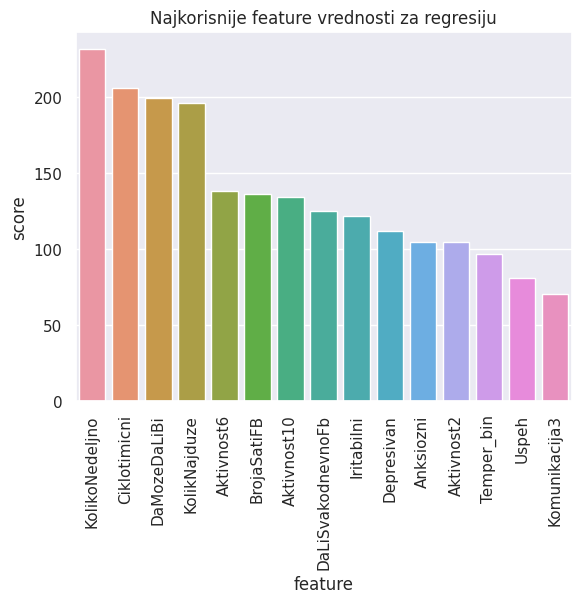

In [42]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za regresiju
best_features = SelectKBest(score_func = f_regression, k=15)
calc_features = best_features.fit(input_cols_reg,output_col_reg)
#odabir najboljih feature-a
usefull_features = pd.DataFrame({'feature' : input_cols_reg.columns.values, 'score' : calc_features.scores_})
most_usefull_features_reg = usefull_features.sort_values(by=['score'],ascending=False).head(15)
#vizuelizacija dobijenih rezultata
plt.title('Najkorisnije feature vrednosti za regresiju')
plt.xlabel('Feature score')
plt.xticks(rotation=90)
plt.ylabel('Naziv kolone')

sns.barplot(x=most_usefull_features_reg['feature'], y=most_usefull_features_reg['score'])
plt.show()

In [43]:
#pravljenje seta sa najznacajnijim feature-ima za regresiju
input_cols_reg_new = new_data[most_usefull_features_reg['feature']]
output_col_reg_new = new_data['PUI']
X_train, X_test, y_train, y_test = train_test_split(input_cols_reg_new, output_col_reg_new, test_size=0.2)

In [44]:
#odabir modela za regresiju
models = [  ('Linear Regression', linear), 
            ('Logistic Regression', logistic),
            ('Lasso', lasso), 
            ('Ridge', ridge), 
            ('Elastic Net', el_net), 
            ('Gradient Boosting', gradient_boost),
            ('Random Forest Regression', random_forest)]
results = []
results_mean_squared_error = []
results_root_mean_squared_error = []
results_r2_score = []
names = []
k_fold = KFold(n_splits=10)
for name, model in models:
    cv_res = cross_validate(model, X_train, y_train, cv=k_fold, scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error','r2'])
    results.append(cv_res)
    results_mean_squared_error.append(cv_res['test_neg_mean_squared_error'].mean())
    results_root_mean_squared_error.append(cv_res['test_neg_root_mean_squared_error'].mean())
    results_r2_score.append(cv_res['test_r2'].mean())
    names.append(name)

                 model_name  neg_mean_squared_error
0         Linear Regression             -125.371367
1       Logistic Regression             -194.605509
2                     Lasso             -149.103258
3                     Ridge             -125.358402
4               Elastic Net             -148.196487
5         Gradient Boosting             -126.684727
6  Random Forest Regression             -130.002434


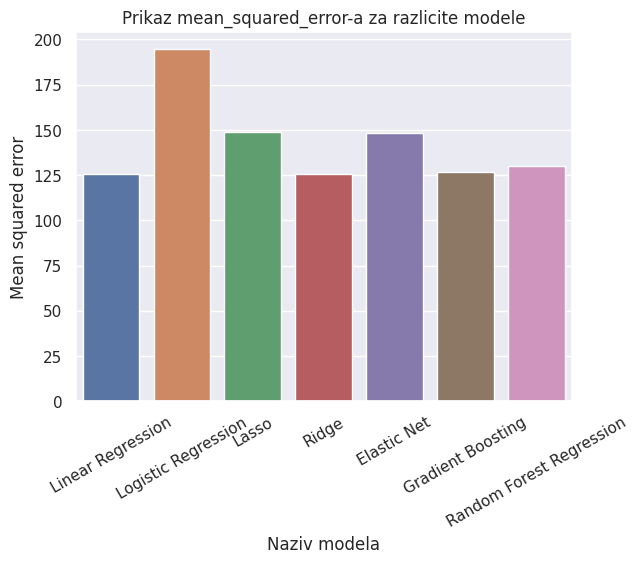

In [45]:
#vizuelizacija dobijenih rezultata za neg_mean_squared_error
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'neg_mean_squared_error':results_mean_squared_error})
sns.barplot(x = frame['model_name'], y=abs(frame['neg_mean_squared_error']))
print(frame)
title = 'Prikaz mean_squared_error-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Mean squared error')
plt.show()

                 model_name  neg_root_mean_squared_error
0         Linear Regression                   -11.172718
1       Logistic Regression                   -13.927147
2                     Lasso                   -12.195889
3                     Ridge                   -11.172195
4               Elastic Net                   -12.157890
5         Gradient Boosting                   -11.240330
6  Random Forest Regression                   -11.384714


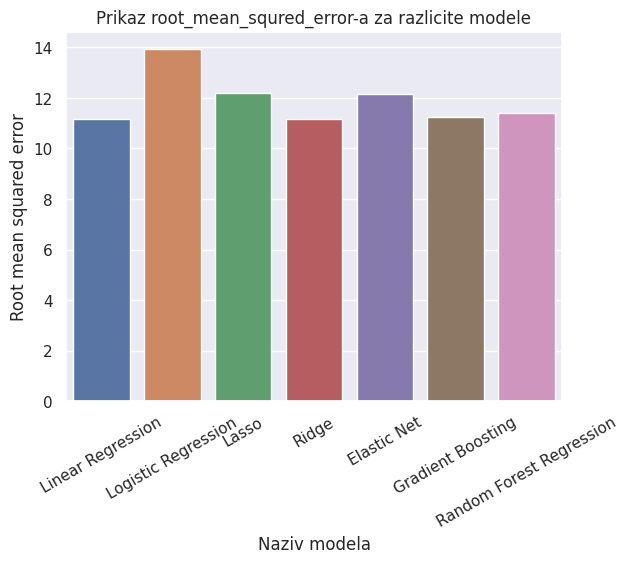

In [46]:
#vizuelizacija dobijenih rezultata za root_mean_squared_error
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'neg_root_mean_squared_error':results_root_mean_squared_error})
print(frame)
sns.barplot(x = frame['model_name'], y=abs(frame['neg_root_mean_squared_error']))
title = 'Prikaz root_mean_squred_error-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Root mean squared error')
plt.show()

                 model_name        r2
0         Linear Regression  0.361315
1       Logistic Regression  0.007998
2                     Lasso  0.240683
3                     Ridge  0.361385
4               Elastic Net  0.245606
5         Gradient Boosting  0.353222
6  Random Forest Regression  0.336804


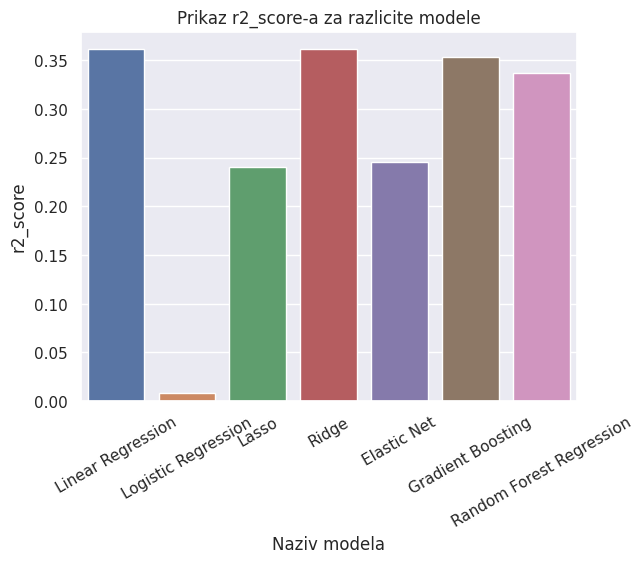

In [47]:
#vizuelizacija dobijenih rezultata za r2_score
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'r2':results_r2_score})
print(frame)
sns.barplot(x = frame['model_name'], y=abs(frame['r2']))
title = 'Prikaz r2_score-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('r2_score')
plt.show()

In [48]:
#auto-sklearn za regresiju
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30)
automl.fit(X_train, y_train)
print(automl.leaderboard())
test_predictions = automl.predict(X_test)
print("Test R2 score:", r2_score(y_test, test_predictions))

          rank  ensemble_weight           type      cost   duration
model_id                                                           
11           1             0.52  liblinear_svr  0.602076   0.616087
4            2             0.28    extra_trees  0.609489  13.913999
2            3             0.20  random_forest  0.624591   2.463046
Test R2 score: 0.3763771096018068
